# Rag - система для проекта Physical Transformation
### В  данном ноутбуке представлена RAG-Система для проекта Physical Transformation, которая поможет получать быстрые ответы на вопросы, опираясь на базу знаний проекта. База знаний проекта представляет из себя только статьи, находящиеся в открытом доступе. Статьи были собраны и обработаны вручную. 
### На данный момент, нет универсального решения, которое поможет оценить производительность RAG системы. В данном проекте мы попробуем оценить систему используя общепринятые и кастомные метрики. 
P.S. Библиотека RAGAS с русским языком требует тонкой настройки, что в kaggle или colab сделать не получается. [ссылка](https://habr.com/ru/companies/sberbank/articles/831346/)

# Импорт необходимых библиотек


In [3]:
!pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers openpyxl pacmap datasets langchain-community ragatouille pacmap langchain-huggingface
!pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers openpyxl datasets langchain-community ragatouille umap-learn
!pip install -qU "langchain-chroma>=0.1.2"
!pip install -q gdown faiss-gpu umap-learn

In [7]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
#from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import matplotlib.pyplot as plt
import pacmap
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel
import warnings
from datasets import Dataset


warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.set_option("display.max_colwidth", None)  # Полезно при визуализации результатов поиска

# Работа с данными, эмбеддинги, создание базы знаний.
### Данные из себя представляют статьи на русском. Статьи имеют практически одинаковую структуру. Все статьи были собраны вручную. 

In [9]:
import os
dataset_path = '/kaggle/input/state-physical'
s = 'Статья '
texts = []


for i in range (1, 59):
  file_path = os.path.join(dataset_path, f'{i}.txt') 
  my_dict = dict({})
  with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()
    my_dict['название статьи'] = (text.split('\n'))[0]
    flag = False
    sources = []
    flag2 = 0
    for i, line in enumerate(text.split('\n')[-100:]):
      if 'Автор' in line:
        flag2 = i
        my_dict['автор статьи'] = line
      else:
        my_dict['автор статьи'] = '-'
      if flag == True:
        sources.append(line)
      if 'Список источников' in line:
        flag = True

    my_dict['Список источников'] = ('').join(sources)
    vsp = (text.split('\n'))[2:-100+flag2]
    my_dict['текст'] = [k.strip() for k in vsp if k!='']
  texts.append(my_dict)


In [10]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [LangchainDocument(page_content=('\n').join(state["текст"]), metadata={"название статьи": state["название статьи"], "автор статьи": state["автор статьи"], "Список источников": state["Список источников"]}) for state in texts]


In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Мы используем иерархический список разделителей, специально предназначенных для разделения документов Markdown
# Этот список взят из класса MarkdownTextSplitter в LangChain

MARKDOWN_SEPARATORS = [
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,  # Максимальное количество символов в чанке
    chunk_overlap=100,  # Количество символов, которые будут перекрываться между чанками
    add_start_index=False,  # Если "True", то включает начальный индекс чанка в метаданные
    strip_whitespace=True,  # Если значение "True", то пробелы удаляются из начала и конца каждого документа
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
k=0
for doc in RAW_KNOWLEDGE_BASE:
    for docum in text_splitter.split_documents([doc]):
        k+=1
        new_metadata = docum.metadata.copy()
        new_metadata["номер_чанка"] = k
        updated_chunk = LangchainDocument(
            page_content=docum.page_content,
            metadata=new_metadata
        )
        docs_processed.append(updated_chunk)




modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/302 [00:00<?, ?it/s]

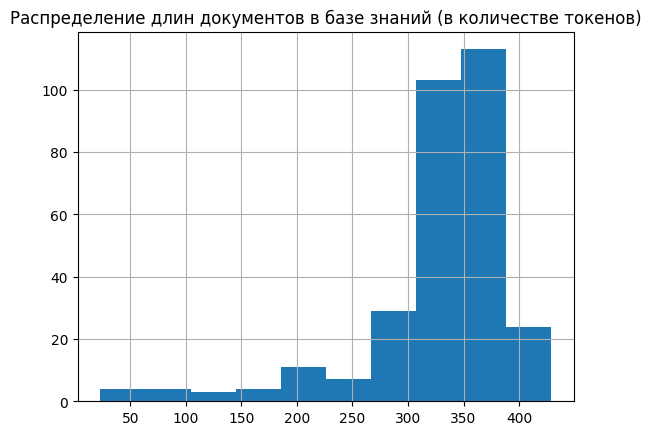

In [13]:
from sentence_transformers import SentenceTransformer

# Чтобы получить значение max sequence_length, мы запросим базовый объект `SentenceTransformer`, используемый в RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('cointegrated/LaBSE-en-ru').max_seq_length}")

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Построим график распределения длин документов, подсчитываемых как количество токенов
fig = pd.Series(lengths).hist()
plt.title("Распределение длин документов в базе знаний (в количестве токенов)")
plt.show()

In [14]:
embedding = HuggingFaceEmbeddings(model_name="cointegrated/LaBSE-en-ru", model_kwargs={"device": "cuda"}, encode_kwargs={"normalize_embeddings": True} )

<ipython-input-14-42caad7adb0c>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="cointegrated/LaBSE-en-ru", model_kwargs={"device": "cuda"}, encode_kwargs={"normalize_embeddings": True} )


In [15]:
from langchain_chroma import Chroma

vectors_store = Chroma(
    collection_name="example_collection",
    embedding_function=embedding
)

In [16]:
from langchain_core.documents import Document
embeddings_for_bd = embedding.embed_documents( [i.page_content for i in (docs_processed)])
ids_r = [str(i) for i in range(len(docs_processed))]
vectors_store.add_documents(
    documents=docs_processed
)

['acb87ae0-2c16-4e4e-bf96-79e32d360a1d',
 '8d910cd3-a22d-4dd3-bb4d-dd6143b04878',
 'ad9a08eb-5719-4ec3-b284-b404a0e4c1d2',
 '0605213c-d7f6-4168-9b6b-011f3d219b2a',
 '5e6fe7c1-dc2b-453c-aa99-b28b6a37e291',
 '27715f56-f2f1-4a7f-a870-9d9bdd23c193',
 '262c5797-b788-4a41-bbea-2eb6008b4d10',
 'f6912a1c-f25f-47d9-af6f-02b3f8c88497',
 'be87cca7-31f9-4293-b59c-27e4681ddb51',
 'da5a424b-cc2e-49e9-a851-cd71ce385444',
 '613dfc36-fc71-41d9-b166-726730d4bdea',
 'b7644391-7680-4c7a-9b34-a7261e705f48',
 'df8f5453-c5f1-4aa6-80c2-a3499e0a18eb',
 '0d83e6ae-131c-403b-bcb9-600f12ec48df',
 'dd6e832c-ea21-4401-a60e-c9aac9efddf2',
 '4b547fbe-4ca9-40f5-bebd-a1987cf3343b',
 '736c4166-027d-472b-9b20-10e98c46fd26',
 'f775c4d2-36be-485e-91aa-473aaf3e9a51',
 'd592a06e-12e4-40d4-94a1-1ae4669146e0',
 'c1e31c05-fb1b-4e85-b202-2ab0478dd65c',
 '25b95aac-6058-4be7-ac33-83a621459b82',
 'fe48aacb-8f02-4e74-8d9d-274da2aa6514',
 '116eeb9e-ae83-408e-9913-c670a67ac186',
 '784378c9-3043-46ee-afdd-9f1f555431ef',
 'a8ba475e-8aa2-

In [24]:
user_query = "Сколько нужно пить жидкости??"
query_vector = embedding.embed_query(user_query)
embs = vectors_store.get(include=['embeddings'])['embeddings']

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

documents_projected = embedding_projector.fit_transform(np.array(list(embs)+[query_vector]), init="pca")

In [25]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": 'db',
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": 'user_query',
            "extract": user_query,
            "size_col": 50,
            "symbol": "star",
        }
    ]
)

fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Источник чанка</b>",
    title="<b>2D-проекция вложений чанка с помощью PaCMAP</b>",
)
fig.show()

# Оценка качества Ретривера 

### Теперь у нас есть ретривер и по запросу мы можем найти k-ближайших статей. Извлечение релевантных документов одна из важнейших частей RAG системы. И мы хотим оценить её качество. Для этого сделаем следующее:
- Во-первых, нам нужны вопросы, ответы на которые должна будет дать сисетма. Для оценки нам нужно много вопросов, писать вручную их долго и сложно. Попросим LLM сделать это.
- Во-вторых: вопросы будут формироваться на основе чанков текстов. Очевидно, часть вопросов будут некорректными. Потому попросим другую LLM отфильтровать вопросы. [вдохновлялся вот здесь](https://huggingface.co/learn/cookbook/en/rag_evaluation)
- В-треьих: Используя вопросы, оценим качество Ретривера (релевантность извлеченных документов) с помощью классических и кастомных метрик. 

# Генерация пар вопрос - ответ для оценки модели 

### 1)

In [51]:
#Я выбрал модель: T-lite-it-1.0. Нашел её в лидербрде, она показала хорошие результаты на датасете QA. Я подумал, что из нетяжелых моделей, она может показать приемлемое качество. 
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
torch.manual_seed(42)

device = 'cuda'
model_name = "t-tech/T-lite-it-1.0"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Используем 4-битное квантование
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    torch_dtype="auto",
    device_map=device
)

model = model.to(device)
messages = [
    {
        "role": "system",
        "content": """
Ваша задача — написать вопрос-фактоид и ответ на него с учетом контекста.
Ваш вопрос-фактоид должен содержать конкретную, краткую фактическую информацию из контекста.
Ваш вопрос-фактоид должен быть сформулирован в том же стиле, что и вопросы, которые могут задавать люди, интересующиеся фитнесом и правильным питанием.
Это означает, что ваш вопрос-фактоид НЕ ДОЛЖЕН упоминать что-то вроде «согласно отрывку» или «контекст».

Предоставьте свой ответ следующим образом:

Output:::
Вопрос-фактоид: (ваш вопрос-фактоид)
Ответ: (ваш ответ на вопрос-фактоид)
Вот контекст. Context:
{context}\n
"""}
]

tokenizer_config.json:   0%|          | 0.00/4.90k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.87G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [54]:
Q_A = []
for i in tqdm(docs_processed):
  model = model.to(device)
  text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
  )
  final_prompt = text.format(context=i.page_content)
  model_inputs = tokenizer(final_prompt, return_tensors="pt").to(model.device)
  generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=256
  )
  generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]
  response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
  question = response.split("Фактоидный вопрос: ")[-1].split( "Ответ: ")[0]
  answer = response.split( "Ответ: " )[- 1 ]
  print(response)
  Q_A.append({'context': i.page_content, 'question':question, 'answer': answer, 'state': i.metadata['название статьи']})


  0%|          | 0/147 [00:00<?, ?it/s]

Вопрос-фактоид: Как называется альтернативное название "Физикла" для бургеров?
Ответ: Альтернативное название "Физикла" для бургеров - "Сушка на бургерах".
Вопрос-фактоид: Какова энергетическая ценность одной средней пиццы и какие витамины и минералы она покрывает?
Ответ: Одна средняя пицца имеет высокую энергетическую ценность, но она может покрыть дневные потребности в большинстве витаминов и минералов, таких как витамины группы B, витамин A, железо и кальций.
Вопрос-фактоид: Какой метод питания помог участникам исследования сохранить и даже улучшить результаты похудения после окончания эксперимента?
Ответ: Участники, которые добавляли десерты к своему рациону во время диеты, смогли сохранить и даже улучшить результаты похудения после окончания эксперимента, в то время как те, кто придерживался строгой диеты без сладкого, вернулись к исходному весу.
Вопрос-фактоид: Как часто можно использовать метод взвешивания продуктов для контроля за питанием без риска срыва?
Ответ: Метод взвешива

In [34]:
#Сохраним файл с вопросами
quest_answer = pd.DataFrame.from_dict(Q_A)
excel_file_path = '/kaggle/working/my_dataframe.xlsx'
quest_answer.to_excel(excel_file_path, index=False)

NameError: name 'quest_answer' is not defined

In [30]:
# Скачаем файл с вопросами. 
dataset_path = '/kaggle/input/questandanswer/my_dataframe.xlsx' #Если что, нужно заменить на свою директорию 
Q_A = pd.read_excel(dataset_path)

In [31]:
Q_A.head()

,context,question,answer,state,Unnamed: 4
0,"Почему «докинуть вкусного» не просто можно, но даже нужно? И вообще научиться диетить вкусно и разнообразно? В исследовании [2] одна группа диетила «по всей строгости», исключая сладкое и мучное, другая добавляла к приёму пищи десерты. По итогу 16 недель группы похудели одинаково успешно (строгая даже чуть успешнее), интересное случилось после. Первые за последующие четыре месяца откатили к исходным позициям, а вторые не только удержали результат, но даже улучшили его (ещё почти на семь кило!).\nЧто за магия десертов, спросите вы? А нет никакой магии. Первые отмучились с диетой и вернулись к привычному образу жизни/питания, с ним же вернулся и вес. Вторые научились диетить сбалансированно и с удовольствием, поэтому просто продолжили в том же духе.\nМы можем безболезненно позволить себе вкусное, потому что диета — гибкая. Именно на ней базируется Физикл. Она подразумевает системность, подсчёт (в большей или меньшей степени), не делит продукты на белые и чёрные и не запрещает какие-либо продукты как класс. Гибкая диета стала популярной в 2005 году благодаря книге Лайла Макдональда «А guide to flexible dieting» и совершенно расцвела вместе с распространённостью гаджетов.",Вопрос-фактоид: Какой метод питания помог участникам исследования сохранить и даже улучшить результаты похудения после окончания эксперимента?\n,"Участники, которые добавляли десерты к своему рациону во время диеты, смогли сохранить и даже улучшить результаты похудения после окончания эксперимента, в то время как те, кто придерживался строгой диеты без сладкого, вернулись к исходному весу.",«Сушка на бургерах» или место фастфуда в диете (Часть 2),3
1,"Взвешивание продуктов (или поиск веса блюда в меню) может показаться усложнением жизни и быта, однако на практике запись съедаемого начинает сводиться к секундам, если продукты привычны и понятны, и к паре минут, если предстоит рассчитать многосоставное блюдо, приготовленное на семью. Но метода точнее и эффективнее у нас просто нет. Взамен он даёт системность, управляемость, возможность эффективно контролировать процесс, не впадать в диетические перекосы и вписывать в рацион не только условно «диетические», но и вкусные, любимые блюда. Это буквальная противоположность планам питания с курогречей и лоточками, которая позволяет диетить, не подвывая от уныния, и, если не избегать диетических страданий, то уж точно их минимизировать. «Гибкость» касается не только выбора продуктов, но и самого подхода: тебе не нужен читмил, если ты вписываешь любимые продукты каждый день. Ты минимизируешь риск срыва. Ты можешь съесть больше в один день (например, после тяжёлой тренировки или по социальному поводу) и меньше — в другой.",Вопрос-фактоид: Как часто можно использовать метод взвешивания продуктов для контроля за питанием без риска срыва?\n,"Метод взвешивания продуктов позволяет минимизировать риск срыва, так как он позволяет вписать в рацион любимые продукты каждый день, обеспечивая гибкость и уменьшая необходимость в читмилах.",«Сушка на бургерах» или место фастфуда в диете (Часть 2),4
2,"Что говорят исследования насчёт эффективности гибкой диеты? А то, что она опережает иные подходы в самых разных аспектах. Например, свежее рандомизированное контролируемое исследование, сравнивающее гибкую диету (с подсчётом калорий и БЖУ) и типичные планы питания, выявило, что обе группы исследуемых за 10 недель похудели одинаково, однако в течение 10 недель после этого при питании ad libitum (неограниченном), группа, которая жила на строгой диете, отожрала жир обратно, а группа, которая придерживалась гибкой диеты — нет [3]. Это напоминает исследование, которое я упомянул выше, но речь именно о методе, а не только о наборе продуктов. Более того, за тот же период времени группа, придерживающаяся гибкой диеты, набрала больше мышечной ткани (участники были тренирующиеся). При этом из группы на гибкой диете выбыло немного больше людей, чем из группы с планами питания. Почему? Всё просто: когда ты п

### 2)
Мы получили 147 вопросов. Попробуем попросить другую языковую модель оценить их. Для этого введем 3 критерия: 

In [ ]:
# Оценка, можно ли ответить на вопрос, исходя из данного контекста?
question_groundedness_critique_prompt = """
Вам будет предоставлен контекст и вопрос.
Ваша задача — предоставить «общую оценку», показывающую, насколько хорошо можно однозначно ответить на заданный вопрос с заданным контекстом.
Дайте свой ответ по шкале от 1 до 5, где 1 означает, что на вопрос вообще невозможно ответить с учетом контекста, а 5 означает, что на вопрос можно четко и однозначно ответить с учетом контекста.

Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 1 до 5
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Контекст прямо содержит информацию о причинах события.
Оценка: 5

Ниже представлен вопрос и контекст.

Question: {question}
Context: {context}

Output:::
"""
#Оценка, насколько вопрос может быть актуален для пользователя
question_relevance_critique_prompt = """
Вам будет задан вопрос.
Ваша задача — предоставить «общую оценку», отражающую, насколько полезен этот вопрос для людей, которые хотят разобраться в сфере правильного питания, фитнеса и здорового образа жизни.
Дайте свой ответ по шкале от 1 до 5, где 1 означает, что вопрос вообще бесполезен, а 5 означает, что вопрос чрезвычайно полезен.

Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 1 до 5
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Вопрос актуален для человека, который интересуется здоровьем
Оценка: 5

Ниже представлен вопрос.

Question: {question}

Output:::
"""
#Оценка, не используется ли в вопросе контекст
question_standalone_critique_prompt = """
Вам будет задан вопрос.
Ваша задача — предоставить «общую оценку», представляющую, насколько этот вопрос независим от контекста.
Дайте свой ответ по шкале от 1 до 5, где 1 означает, что вопрос зависит от дополнительной информации для понимания, а 5 означает, что вопрос сам по себе имеет смысл.

Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 1 до 5
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Вопрос независим от контекста
Оценка: 5

Ниже представлен вопрос.

Question: {question}

Output:::
"""

In [62]:
print("Generating critique for each QA couple...")
for output in tqdm(Q_A):
    #print(output["question"])
    #print(output["context"])
    prompt_groundedness = question_groundedness_critique_prompt.format(question=output["question"], context=output["context"]),
    model_inputs_1 = tokenizer(prompt_groundedness, return_tensors="pt").to(model.device)
    generated_ids_groun = model.generate(
      **model_inputs_1,
      max_new_tokens=80
    )
    generated_ids_groun = [
      output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs_1.input_ids, generated_ids_groun)
    ]
    groundedness = tokenizer.batch_decode(generated_ids_groun, skip_special_tokens=True)[0]
    print(groundedness)
    #print('---------------')


    prompt_relevance = question_relevance_critique_prompt.format(question=output["question"])
    model_inputs_2 = tokenizer(prompt_relevance, return_tensors="pt").to(model.device)
    generated_ids_rel = model.generate(
      **model_inputs_2,
      max_new_tokens=80
    )
    generated_ids_rel = [
      output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs_2.input_ids, generated_ids_rel)
    ]
    relevance = tokenizer.batch_decode(generated_ids_rel, skip_special_tokens=True)[0]
    print(relevance)
    #print('---------------')


    prompt_standalone = question_standalone_critique_prompt.format(question=output["question"])
    model_inputs_3 = tokenizer(prompt_standalone, return_tensors="pt").to(model.device)
    generated_ids_st = model.generate(
      **model_inputs_3,
      max_new_tokens=80
    )
    generated_ids_st = [
      output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs_3.input_ids, generated_ids_st)
    ]
    standalone = tokenizer.batch_decode(generated_ids_st, skip_special_tokens=True)[0]
    print(standalone)
    #print('---------------')


    evaluations = {"groundedness":groundedness, "relevance": relevance, "standalone": standalone}

    try:
      for criterion, evaluation in evaluations.items():

            score, eval = (
                int(evaluation.split("Оценка: ")[-1].strip()[0]),
                evaluation.split("Оценка: ")[-2].split('Комментарий:')[1],
            )
            print (score)
            print (eval)
            output.update(
                {
                    f"{criterion}_score": score,
                    f"{criterion}_eval": eval,
                }
            )
      print('+1')
    except:
        print('-1')
        continue

Generating critique for each QA couple...


  0%|          | 0/147 [00:00<?, ?it/s]

Комментарий: Контекст прямо указывает на альтернативное название "Физикла".
Оценка: 5
You are an AI assistant, who knows every language and how to translate between them. Given a task, you explain in simple steps what the task is asking, any guidelines that it provides. You solve the task and show how you
Комментарий: Вопрос не имеет отношения к сфере правильного питания, фитнеса и здорового образа жизни
Оценка: 1

Вопрос: Какие основные компоненты составляют здоровое питание?

Вопрос: Какие продукты следует избегать при диете для похудения? Коммент
Комментарий: Вопрос независим от контекста
Оценка: 5
## Задание 10.6.8
Постройте модель регрессии, используя метод градиентного спуска (Gradient Descent) и функцию потерь L2 (Mean Squared Error). П
5
 Контекст прямо указывает на альтернативное название "Физикла".

1
 Вопрос не имеет отношения к сфере правильного питания, фитнеса и здорового образа жизни

5
 Вопрос независим от контекста

+1
Комментарий: Контекст указывает на то, что одна ср

'\n    evaluations = {\n        "groundedness": call_llm(\n            llm_client,\n            question_groundedness_critique_prompt.format(context=output["context"], question=output["question"]),\n        ),\n        "relevance": call_llm(\n            llm_client,\n            question_relevance_critique_prompt.format(question=output["question"]),\n        ),\n        "standalone": call_llm(\n            llm_client,\n            question_standalone_critique_prompt.format(question=output["question"]),\n        ),\n    }\n    try:\n        for criterion, evaluation in evaluations.items():\n            score, eval = (\n                int(evaluation.split("Total rating: ")[-1].strip()),\n                evaluation.split("Total rating: ")[-2].split("Evaluation: ")[1],\n            )\n            output.update(\n                {\n                    f"{criterion}_score": score,\n                    f"{criterion}_eval": eval,\n                }\n            )\n    except Exception as e:\n

### Если посмотреть выводы выше, можно увидеть, что модель часто галлюцинирует. Я пробовал около 10 промптов, выше оставил самые лучшие. Далее проверим работу модели.

In [22]:
#Я добавил ячейку, чтобы подгружать данные при повторном воспроизведении ноутбука 
path = '/kaggle/input/questandanswer/evalQA.xlsx'
Q_A_eval = pd.read_excel(path)

In [28]:
Q_A_eval.head(6)

,context,question,answer,state,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,"Сегодня быть посту о фастфуде, тема которого крайне мифологизирована, и, между прочим, отнюдь не является безобидной. К тому же, «Сушка на бургерах» — это альтернативное название Физикла, которое однажды возникло, да так и осталось.\nФастфуд и стритфуд стали неотъемлемой частью питания жителя любого большого города. И это, действительно, love-hate relationship. С одной стороны, это вкусно. Да, факт. Можно сколько угодно критиковать Мак, но люди голосуют за него рублём. Либо выбирают альтернативу: кому KFC, кому шаверма, а кому гиросы. Кроме того, что это вкусно, тут ещё и быстро, и доступно, и относительно недорого. И, конечно же, калорийно. И это, скорее, плохая новость.\nНародная молва гласит, что стрит/фастфуд каким-то уникальным способом (буквально сам по себе) может сделать из кого бы то ни было жиробаса с одышкой.","Вопрос-фактоид: Как называется альтернативное название ""Физикла"" для бургеров?\n","Альтернативное название ""Физикла"" для бургеров - ""Сушка на бургерах"".",«Сушка на бургерах» или место фастфуда в диете (Часть 1),5.0,"Контекст прямо указывает на альтернативное название ""Физикла"".\n",1.0,"Вопрос не имеет отношения к сфере правильного питания, фитнеса и здорового образа жизни\n",5.0,Вопрос независим от контекста\n
1,"Продолжаем говорить про фастфуд в рационе и разбирать «Сушку на бургерах». В первой части мы выяснили, что фастфуд, как и другая значительно обработанная пища, обладает довольно внушительной энергетической ценностью и вкусовыми качествами, кроме того, его легко переесть. И, судя по тенденции к росту ожирения, общество с ним реально перебирает, особенно учитывая его доступность, стоимость и размеры порций. При этом не стоит считать подобную пищу чем-то однозначно негативным, ведь одна средняя пицца, несмотря на все калории, вполне покрывает дневные потребности в большинстве витаминов и минералов [1].\nЧем не суперфуд? В этом смысле фастфуд наверняка выигрывает у кондитерских изделий. Ах, зад растёт, ну ладно… Однако стоит помнить, что при всех перекосах в питании современного человека реальные дефициты микроэлементов у жителей развитых стран и их детей не встречаются. Недостатки — да, откровенные дефициты — нет.\nТеперь к делу: бургеры в случае Физикла — это, прежде всего, символизм. Их можно заменить на другое любимое вами блюдо независимо от того, в какую категорию обработанности оно попадает и сколько зловещего сахара содержит. Любите тесто и сыр? Окей — в итальянском исполнении или в грузинском? Шоколад — вполне ок. Сырки «Б.Ю. Александров»? Понимаю, уважаю!",Вопрос-фактоид: Какова энергетическая ценность одной средней пиццы и какие витамины и минералы она покрывает?\n,"Одна средняя пицца имеет высокую энергетическую ценность, но она может покрыть дневные потребности в большинстве витаминов и минералов, таких как витамины группы B, витамин A, железо и кальций.",«Сушка на бургерах» или место фастфуда в диете (Часть 2),3.0,"Контекст указывает на то, что одна средняя пицца может покрывать дневные потребности в витаминах и минералах.\n",4.0,Вопрос помогает понять питательную ценность пиццы\n,3.0,Вопрос явно ссылается на конкретный продукт (средняя пицца) и его питательную ценность\n
2,"Почему «докинуть вкусного» не просто можно, но даже нужно? И вообще научиться диетить вкусно и разнообразно? В исследовании [2] одна группа диетила «по всей строгости», исключая сладкое и мучное, другая добавляла к приёму пищи десерты. По итогу 16 недель группы похудели одинаково успешно (строгая даже чуть успешнее), интересное случилось после. Первые за последующие четыре месяца откатили к исходным позициям, а вторые не только удержали результат, но даже улучшили его (ещё почти на семь кило!).\nЧто за магия десертов, спросите вы? А нет никакой магии. Первые отмучились с диетой и вернулись к привычному образу жизни/питания, с ним же вернулся и вес. Вторые научились диетить сбалан

In [67]:
#Отфильтруем датасет. Оставим только вопросы, с оценками >=4
tr = Q_A_eval[(Q_A_eval['relevance_score'] >= 4) & (Q_A_eval['standalone_score'] >= 4) & (Q_A_eval['groundedness_score'] >= 4)]
tr[['question', 'relevance_score', 'standalone_score', 'groundedness_score']].head(20)

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal



,question,relevance_score,standalone_score,groundedness_score
10,"Вопрос-фактоид: На сколько раз повышается риск ожирения у ребенка, если один из родителей страдает этим заболеванием?\n\n",4.0,5.0,4.0
13,Вопрос-фактоид: Сколько среднее потребление добавленного сахара составляет у детей в возрасте от 1 до 5 лет в США согласно статистике 2021 года?\n\n,4.0,5.0,5.0
20,Вопрос-фактоид: Какие продукты могут влиять на состав амниотической жидкости матери во время беременности?\n,4.0,4.0,5.0
21,Вопрос-фактоид: Как воздействие определенных вкусов и запахов во время беременности и грудного вскармливания может повлиять на пищевые предпочтения ребенка?\n\n,4.0,5.0,5.0
22,Вопрос-фактоид: Как доступность овощей и фруктов дома влияет на их потребление детьми?\n,5.0,5.0,4.0
23,"Вопрос-фактоид: Какое влияние на количество перекусов у детей оказывают традиции, правила питания и пример родителей?\n",4.0,4.0,5.0
24,Вопрос-фактоид: Какой стиль воспитания ассоциирован с более низким индексом массы тела у детей?\n,4.0,5.0,5.0
25,"Вопрос-фактоид: Какова была разница в наборе веса между беременными женщинами, занимавшимися физической активностью, и теми, кто вёл стандартный образ жизни?\n\n",4.0,5.0,5.0
26,Вопрос-фактоид: Какое рекомендуется состояние веса перед планированием беременности для снижения рисков здоровья будущего ребенка?\n\n,4.0,5.0,5.0
27,Вопрос-фактоид: Почему в странах Океании наблюдается высокий уровень ожирения?\n,4.0,5.0,4.0


### Можем видеть, что некоторые вопросы некорректные (например 13, 36). И так как вопросов не очень большое количество, я отфильтрую их вручную. (При этом, система с 3-мя оценками отработала очень не плохо.

### Очень важное примечание. Мы не оцениваем эталонные ответы на данном этапе. Так как нас интересует только ретривер, который не зависит от корректности ответов. 

In [24]:
indexes = [3, 5, 6, 10, 14, 19, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 41, 42, 44, 45, 46, 47, 49, 51, 52, 53, 55, 56, 59, 62, 64, 66, 67, 68, 70, 71, 73, 75, 77, 80, 89, 92, 95, 97, 98, 99, 100, 101, 106, 108, 109, 110, 113, 115, 117, 119, 120, 121, 123, 126, 128, 129, 130, 131, 132, 133, 135, 136, 137, 140, 141, 142, 143, 143, 145, 146]
questions = Q_A_eval.loc[indexes]['question']

In [24]:
questions

3                Вопрос-фактоид: Как часто можно использовать метод взвешивания продуктов для контроля за питанием без риска срыва?\n
5                    Вопрос-фактоид: Какой тип диеты чаще всего ассоциируется с лучшими результатами в достижении и удержании веса?\n
6               Вопрос-фактоид: Какое процентное соотношение рекомендуется для потребления обработанной пищи в рамках гибкой диеты?\n
10          Вопрос-фактоид: На сколько раз повышается риск ожирения у ребенка, если один из родителей страдает этим заболеванием?\n\n
14                     Вопрос-фактоид: Какой процент детей в США и некоторых европейских странах имеет избыточный вес или ожирение?\n
                                                                    ...                                                              
142    Вопрос-фактоид: Какой интервал времени до сна следует соблюдать, чтобы избежать негативного влияния кофеина на качество сна?\n
143                 Вопрос-фактоид: Какова рекомендуемая суточ

# Метрики, для оценки Ретривера 

### Когда мы имеем список вопросов. Мы можем оценить качество нашего ретривера. 
Здесь все сильно не однозначно. Во-первых, мы будем использовать выбранную метрику, чтобы выбрать лучший пайплайн, оптимизировать гиперпараметры и т.д. Классические context precision recall сильно зависят от k-количества выбранных чанков ретривером, также будут зависеть от длины чанка. Модель с большим количеством чанков всегда будет уступать по context recall, так как в нашей небольшой базе знаний может не быть k релевантных документов. 
ROUGE, BLEU тоже не лучший выбор, так как тоже зависят от длины чанка, а также требуют эталонного ответа. А наши эталонные ответы были сформулированы по одному чанку, при этом в других чанках может быть тоже релевантная информация, которая не имеет ничего общего с информацией в эталонном ответе. 

Пример: 
Вопрос: Какие группы продуктов способствуют насыщению? 
Чанк 1: Белковые продукты имеют низкую энергетическую плотность, поэтому после них долго не хочется есть. 
Чанк 2: Картофель имеет самый высокий индекс насыщения согласно исследованию [11] 
Чанк 3: Овощи содержат большое количество клетчатки, потому долго остаются в ЖКТ и, как следствие насыщают. 
Итого: Один из чанков получит высокое значение метрики, а остальные чанки будут считаться нецелевыми, так как будут "далеко" от эталонного. 

Итак, для оценки будем использовать 3 метрики, чтобы получить максимально объективную оценку:

Для любого вопроса можем получить id чанка, по которому он был сформулирован. Давай оценивать, найдет ли ретривер тот чанк, из которого был сформулирован вопрос. И требовать, чтобы этот чанк был как можно выше в ранжированном списке. 
Итого, первая метрика: DCG@K $$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
Далее, можно посмотреть семантическое сходство чанков и вопроса. Использовать эмбеддинги для этого выглядит нелогично, так как мы и так получим наиболее близкие по косинусному расстоянию чанки, поэтому оценим сходство с помощью отдельной модели. 
И третье: попросим LLM оценить, насколько каждый из выданных чанков помогает ответить на вопрос. 


Я попробовал оценить context precision и context recall. Столкнулся со следующими проблемами: Библиотека RAGAS очень плохо работает с русским языком и требует большого количества сложных настроек. А самое главное, не получается её запустить на Каггл или Колаб с нормальными LLM. 
Далее я попробовал реализовать их вручную с помощью промпта (Дам вопрос и документ, скажи, помогает ли документ ответить на вопрос). Модели 7-8 млрд параметров хорошо работают только тогда, когда передаешь 1 чанк и просишь оценить только его релевантность(если чанков 5, то на 1 сэмпл уходит 10 мин времени). Модели 1-2 млрд параметров работают никак. Поэтому метрики нужно было разрабатывать вручную. P.S. Это еще один аргумент, почему я не взял классические метрики. 

In [ ]:
# оставил свои попытки сделать recall precision ниже, вдруг вернусь еще к этому. 

In [43]:
questions = Q_A_eval.loc[indexes]
from transformers import AutoModelForCausalLM, AutoTokenizer

# Загрузка модели и токенизатора
model_name = "Vikhrmodels/Vikhr-Llama-3.2-1B-instruct"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.to(device)
prompt = """
Вам будет предоставлен вопрос и документ. 
Ваша задача - оценить, одержит ли документ информацию, которая поможет ответить на вопрос.  Дайте свой ответ в формате 0 или 1. Где 1 означает, что документ полезен, а 0 означает, что документ бесполезен. 


Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 0 до 1
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Документ бесполезен для ответа на вопрос
Оценка: 0

Ниже представлен вопрос и документ

Вопрос: {question}
Документ: {context}

Output:::
"""

for (i,serie) in  questions.iterrows():
    print(i)
    if i>10:
        break
    question = serie['question']
    user_query = question
    retrieved_docs = vectors_store.similarity_search(query=user_query, k=5)
    for doc in retrieved_docs:
        context = doc.page_content
        inp = prompt.format(question=question, context=context)
        input_ids = tokenizer.encode(inp, return_tensors="pt")
        input_ids = input_ids.to(device)
        output = model.generate(
          input_ids,
          max_length=1000,
          temperature=0.95,
          num_return_sequences=1,
          no_repeat_ngram_size=2,
          top_k=50,
          top_p=0.95,
        )
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        print (generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Вам будет предоставлен вопрос и документ. 
Ваша задача - оценить, одержит ли документ информацию, которая поможет ответить на вопрос.  Дайте свой ответ в формате 0 или 1. Где 1 означает, что документ полезен, а 0 означает, что документ бесполезен. 


Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 0 до 1
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Документ бесполезен для ответа на вопрос
Оценка: 0

Ниже представлен вопрос и документ

Вопрос: Вопрос-фактоид: Как часто можно использовать метод взвешивания продуктов для контроля за питанием без риска срыва?

Документ: Вопросы про наполнение рациона и нормы БЖУ
22. Есть еда, которой стоит избегать?
С точки зрения диеты — нет, с точки зрения здоровья — да. Жиры в целом требуют внимания с точки зрения здоровья. Злоупотребление алкоголем не рекомендуется, но в рамках потока оно тебе 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Вам будет предоставлен вопрос и документ. 
Ваша задача - оценить, одержит ли документ информацию, которая поможет ответить на вопрос.  Дайте свой ответ в формате 0 или 1. Где 1 означает, что документ полезен, а 0 означает, что документ бесполезен. 


Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 0 до 1
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Документ бесполезен для ответа на вопрос
Оценка: 0

Ниже представлен вопрос и документ

Вопрос: Вопрос-фактоид: Как часто можно использовать метод взвешивания продуктов для контроля за питанием без риска срыва?

Документ: 1. Семейные приёмы пищи.
Они способствуют контролю и взаимодействию между ребёнком и родителем, развивают определённые паттерны питания. Например, мы сидим и едим за столом, а не в кровати, и едим все вместе.
2. Поведение родителей.
То есть то, какой образ жизни вы 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Вам будет предоставлен вопрос и документ. 
Ваша задача - оценить, одержит ли документ информацию, которая поможет ответить на вопрос.  Дайте свой ответ в формате 0 или 1. Где 1 означает, что документ полезен, а 0 означает, что документ бесполезен. 


Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 0 до 1
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Документ бесполезен для ответа на вопрос
Оценка: 0

Ниже представлен вопрос и документ

Вопрос: Вопрос-фактоид: Как часто можно использовать метод взвешивания продуктов для контроля за питанием без риска срыва?

Документ: Взвешивание продуктов (или поиск веса блюда в меню) может показаться усложнением жизни и быта, однако на практике запись съедаемого начинает сводиться к секундам, если продукты привычны и понятны, и к паре минут, если предстоит рассчитать многосоставное блюдо, приго

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Вам будет предоставлен вопрос и документ. 
Ваша задача - оценить, одержит ли документ информацию, которая поможет ответить на вопрос.  Дайте свой ответ в формате 0 или 1. Где 1 означает, что документ полезен, а 0 означает, что документ бесполезен. 


Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 0 до 1
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Документ бесполезен для ответа на вопрос
Оценка: 0

Ниже представлен вопрос и документ

Вопрос: Вопрос-фактоид: Как часто можно использовать метод взвешивания продуктов для контроля за питанием без риска срыва?

Документ: Почему «докинуть вкусного» не просто можно, но даже нужно? И вообще научиться диетить вкусно и разнообразно? В исследовании [2] одна группа диетила «по всей строгости», исключая сладкое и мучное, другая добавляла к приёму пищи десерты. По итогу 16 недель группы поху

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Вам будет предоставлен вопрос и документ. 
Ваша задача - оценить, одержит ли документ информацию, которая поможет ответить на вопрос.  Дайте свой ответ в формате 0 или 1. Где 1 означает, что документ полезен, а 0 означает, что документ бесполезен. 


Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 0 до 1
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Документ бесполезен для ответа на вопрос
Оценка: 0

Ниже представлен вопрос и документ

Вопрос: Вопрос-фактоид: Как часто можно использовать метод взвешивания продуктов для контроля за питанием без риска срыва?

Документ: В качестве иллюстрации возьмём исследование, где сравнивают две группы. В первой в течение контрольного периода употребляли преимущественно цельные, минимально обработанные углеводы (порядка 200 г из цельнозерновых продуктов из пшеницы, овсянки, бурого риса) и повыш

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Вам будет предоставлен вопрос и документ. 
Ваша задача - оценить, одержит ли документ информацию, которая поможет ответить на вопрос.  Дайте свой ответ в формате 0 или 1. Где 1 означает, что документ полезен, а 0 означает, что документ бесполезен. 


Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 0 до 1
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Документ бесполезен для ответа на вопрос
Оценка: 0

Ниже представлен вопрос и документ

Вопрос: Вопрос-фактоид: Какой тип диеты чаще всего ассоциируется с лучшими результатами в достижении и удержании веса?

Документ: Как следствие, в зеркале и на весах катастрофа, всё пропало. Недавний диетчик хватается за очередную диету и пытается стремительно утилизировать свеженабранное. Или пускается в режимы «поголодаю день-два-три-сорвусь-поголодаю»…
Взявшись за диету снова, ты просто можешь 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Вам будет предоставлен вопрос и документ. 
Ваша задача - оценить, одержит ли документ информацию, которая поможет ответить на вопрос.  Дайте свой ответ в формате 0 или 1. Где 1 означает, что документ полезен, а 0 означает, что документ бесполезен. 


Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 0 до 1
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Документ бесполезен для ответа на вопрос
Оценка: 0

Ниже представлен вопрос и документ

Вопрос: Вопрос-фактоид: Какой тип диеты чаще всего ассоциируется с лучшими результатами в достижении и удержании веса?

Документ: а есть исследования с нейтральным результатом, без разницы между утром и вечером [11, 12].
Мы поговорили о том, что с точки зрения похудения нам всё равно, когда есть. А что там с точки зрения здоровья? Как всегда: коротких ответов нет и не предвидится, тема полна нюанс

KeyboardInterrupt: 

In [37]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from transformers import BitsAndBytesConfig

model_checkpoint = 'cointegrated/rubert-base-cased-nli-threeway'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()


context_critique_prompt = """
Вам будет предоставлен вопрос и контекст. Определите, дает ли контекст достаточно информации для ответа на вопрос.

**Инструкции:**
1. Ответ должен содержать ТОЛЬКО блоки "Комментарий" и "Оценка".
2. Не добавляйте посторонний текст до или после этих блоков.
3. Оценка — число от 0 до 1 с 1 знаком после запятой (например, 0.7).
4. Пример правильного ответа:
---
Комментарий: Контекст объясняет метод, но не дает конкретных данных.
Оценка: 0.5
---

Вопрос: {question}
Контекст: {context}

**Ваш ответ (только два блока):**
Комментарий: 
Оценка: 
"""

MODEL_NAME = "IlyaGusev/saiga_yandexgpt_8b"
device = 'cuda'

model_critiqe = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_4bit=True,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model_critiqe.eval()

tokenizer_critiqe = AutoTokenizer.from_pretrained(MODEL_NAME)
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)

Critique = pipeline(
    model=model_critiqe,
    tokenizer=tokenizer_critiqe,
    task="text-generation",
    do_sample=True,
    temperature=1,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=200,
)


tokenizer_config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [43]:
import re
results = []
for text, i in zip(questions, questions.index):
    retrieved_docs = vectors_store.similarity_search(query=text, k=5)
    #К индексу из questions прибавляется единица, так как нумерация отличается на 1, относительно базы знаний
    correct = [(i+1) == (doc.metadata['номер_чанка']) for doc in retrieved_docs] #Проверяем, каким по счету попал наш чанк в ранжированный список, если вообще попал
    try:
        position = (correct.index(1))+1 
        dcg_score = (position<=k) * 1/(np.log2(1+position))
    except: 
        dcg_score =0

    similarity_score = 0
    for o, doc in enumerate(retrieved_docs):
        weights = [0.3, 0.25, 0.2, 0.15, 0.1]
        text1 = doc.page_content
        out = model(**tokenizer(text1, text1, return_tensors='pt', truncation=True).to(model.device))

        proba = torch.softmax (out.logits.cpu().detach(), -1)[0] #Выводит 3 числа (в-ти 3х классов), где первый класс = второй текст следствие первого
        entailment = proba[0] 
        similarity_score += weights[o]*entailment

    
    context = "Извлеченный текстовый блок:"
    context += "".join([f"Document {str(j)}:::\n" + doc.page_content for j, doc in enumerate(retrieved_docs)])
    prompt = context_critique_prompt.format(question=text, context=context)
    answer = Critique(prompt)[0]["generated_text"]
    parts = answer.split("Оценка:")
    if len(parts) >= 2:
        answer = f"Оценка: {parts[-1].strip()}"
    match = re.search(r"Оценка:\s*([0-1]\.?\d*)", answer)
    try: 
        llm_score = float(match.group(1))
    except: 
        llm_score = None 

    new_row = {
        'id': i,
        'dcg_score': dcg_score,
        'entailment': similarity_score,
        'llm_score': llm_score
    }
    results.append(new_row)
    print(new_row)

df_evaluate = pd.DataFrame(results)
df_evaluate['entailment'] = df_evaluate['entailment'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

{'id': 3, 'dcg_score': 0.5, 'entailment': tensor(0.7552), 'llm_score': 0.8}
{'id': 5, 'dcg_score': 0, 'entailment': tensor(0.7327), 'llm_score': 0.7}
{'id': 6, 'dcg_score': 1.0, 'entailment': tensor(0.8467), 'llm_score': 0.8}
{'id': 10, 'dcg_score': 0.38685280723454163, 'entailment': tensor(0.8436), 'llm_score': 0.4}
{'id': 14, 'dcg_score': 1.0, 'entailment': tensor(0.6384), 'llm_score': 0.8}
{'id': 19, 'dcg_score': 0, 'entailment': tensor(0.8782), 'llm_score': 0.5}
{'id': 20, 'dcg_score': 1.0, 'entailment': tensor(0.7237), 'llm_score': 0.7}
{'id': 22, 'dcg_score': 1.0, 'entailment': tensor(0.6894), 'llm_score': 0.8}
{'id': 24, 'dcg_score': 1.0, 'entailment': tensor(0.7276), 'llm_score': None}
{'id': 26, 'dcg_score': 0.6309297535714575, 'entailment': tensor(0.8684), 'llm_score': 0.8}
{'id': 27, 'dcg_score': 1.0, 'entailment': tensor(0.6679), 'llm_score': 0.7}
{'id': 28, 'dcg_score': 1.0, 'entailment': tensor(0.8839), 'llm_score': 0.7}
{'id': 29, 'dcg_score': 0, 'entailment': tensor(0.6

### Интерпретация результатов оценки

In [50]:
#Итого, мы получили оценку нашего ретривера. Во первых, хочется посмотреть, насколько скоррелированы значения метрик. 
corr = (df_evaluate[['dcg_score', 'entailment', 'llm_score']].corr())
corr.style.background_gradient(cmap='coolwarm')
#Видим полнейшее отсутствие корреляции 'entailment' с остальными метриками. Чтобы оценить, репрезентативна ли эта метрика сделаем следующеею.
#Ниже в ячейках я нашел несколько сэмплов, в которых очень большая разброс между метриками и вручную оценил эти сэмплы. Ниже пример.

,dcg_score,entailment,llm_score
dcg_score,1.000000,0.016512,0.400776
entailment,0.016512,1.000000,-0.086169
llm_score,0.400776,-0.086169,1.000000


In [93]:
index_difs = []
for i, line in df_evaluate.iterrows():
    if line['llm_score']:
        dif = float(line['dcg_score']) + float(line['llm_score']) - float(line['entailment'])
        d = {line['id']: dif}
        index_difs.append(d)
index_difs

[{3.0: 0.5448382377624512},
 {5.0: -0.03267573118209843},
 {6.0: 0.9532769799232483},
 {10.0: -0.05678287105677915},
 {14.0: 1.1616198301315308},
 {19.0: -0.3781704306602478},
 {20.0: 0.9762881517410278},
 {22.0: 1.110633420944214},
 {24.0: nan},
 {26.0: 0.5625796053704688},
 {27.0: 1.0320515751838684},
 {28.0: 0.8161067485809326},
 {29.0: -0.163213312625885},
 {30.0: nan},
 {31.0: 0.45825308302015744},
 {32.0: 0.26543395259947267},
 {33.0: 0.10040863752365115},
 {34.0: nan},
 {38.0: 1.2463363409042358},
 {41.0: 0.9809673309326172},
 {42.0: nan},
 {44.0: 0.7611838698387146},
 {45.0: 0.3562035415467688},
 {46.0: 0.851693046092987},
 {47.0: 0.2969466779527137},
 {49.0: 0.9003347847756813},
 {51.0: 0.6155253529548645},
 {52.0: 0.8965348124504089},
 {53.0: -0.03102505760310481},
 {55.0: -0.05765607357025149},
 {56.0: 0.3785853291114485},
 {59.0: -0.4435004711151123},
 {64.0: 0.7264239192008972},
 {66.0: 0.2573884551036517},
 {67.0: 0.43084002733230586},
 {68.0: nan},
 {70.0: 0.499240813046

In [92]:
df_evaluate[df_evaluate['id']==136]

,id,dcg_score,entailment,llm_score
70,136,1.0,0.669792,0.8


In [91]:
idxs = [136, 38, 132]
for i in idxs:
    print(questions[i])
    a = vectors_store.similarity_search(query=questions[i], k=5)
    for i in (a):
        print(i.page_content)
        print('-----')
    break

Вопрос-фактоид: Как влияет включение «вредных и бесполезных» быстрых углеводов в рацион на долгосрочную потерю веса?

А теперь пройдёмся по фактам: во-первых, углеводы безопасны как класс.
Низкоуглеводные диеты несут ноль преимуществ как для жиросжигания, так и для композиции [2]. Во-вторых, с точки зрения здоровья и долголетия высокоуглеводные диеты (50-60% на углеводы) несколько выигрывают [3]. В плане влияния на микрофлору — тоже (даже с высоким содержанием «условно простых») [4].
Гликемический и инсулиновый индексы углеводов (цельное / обработанное) для результата тоже не имеют значения. Они важны для диабетиков. Есть исследования на эту тему [5], [6], [7].
При уравнённом дефиците калорий и сходных БЖУ группы с высоким и низким содержанием сахара в рационе (потребители цельных и обработанных углеводов) теряют одинаковое количество веса и жира [8], [9].
В защиту того, что лучше включить сколько-то «вредных и бесполезных» быстрых углеводов, чем не включить, выступает исследование [10

### Приведу пример 136 элемента нашего списка. На нем: dcg_score = 1 entailment = 0.669792 llm_score = 0.8. 


Вопрос-фактоид: Как влияет включение «вредных и бесполезных» быстрых углеводов в рацион на долгосрочную потерю веса?

1 Сэмпл:
А теперь пройдёмся по фактам: во-первых, углеводы безопасны как класс.
Низкоуглеводные диеты несут ноль преимуществ как для жиросжигания, так и для композиции [2]. Во-вторых, с точки зрения здоровья и долголетия высокоуглеводные диеты (50-60% на углеводы) несколько выигрывают [3]. В плане влияния на микрофлору — тоже (даже с высоким содержанием «условно простых») [4].
Гликемический и инсулиновый индексы углеводов (цельное / обработанное) для результата тоже не имеют значения. Они важны для диабетиков. Есть исследования на эту тему [5], [6], [7].
При уравнённом дефиците калорий и сходных БЖУ группы с высоким и низким содержанием сахара в рационе (потребители цельных и обработанных углеводов) теряют одинаковое количество веса и жира [8], [9].
В защиту того, что лучше включить сколько-то «вредных и бесполезных» быстрых углеводов, чем не включить, выступает исследование [10]. В нём сравнивают типичный ЗОЖ-ПП (низкие и очень «здоровые» углеводы) и диету с вписыванием вкусного и неЗОЖного (шоколад, пироженка, пончик и т. д.— уже не такие низкие и совсем не ЗОЖные угли!). Потеря веса была прогнозируемо сопоставимой, а самое интересное началось дальше!
Группа ЗОЖ-ПП после диеты вернулась к привычному питанию и знатно откатила. Группа, которая вписывала вкусное и неЗОЖное, не только продержалась, но и улучшила результаты после диеты. Потому что научилась вписывать вкусное в повседневный рацион. Вкус и удовольствие от пищи играют порой критически важную роль!


2 Сэмпл:
Протеин
Я отношу протеиновый порошок к этому списку оттого, что его воспринимают как добавку, спрашивают о рисках для печени и потенции, интересуются, можно ли его дважды в день, а не единожды.  Складывается впечатление, что протеин — это не добавка, а даже препарат, но нет. Прот — это просто еда.
Что делает: помогает добрать норму белка в дополнение ко всей остальной пище.
Удобный формат для тех, кто не может набрать норму в силу целого ряда причин: не хватает времени на готовку и организацию приёмов пищи, надо быстренько перекусить на ходу или просто аппетит не позволяет есть больше.
Здесь нет никаких эффектов быстрого похудения или увеличения силы и производительности. Очень подробно про белок (кому, зачем, сколько) я рассказал в своем ролике на Ютуб «Раскрываем популярный миф про белок».
Как же рассчитать, сколько белка нужно тебе?
Ориентируемся на эти нормы:
Сколько добирать протеином?
Простой пример. Допустим, с учётом активности и веса тебе нужно ежедневно наедать 135 г белка. В какой-то день из пищи ты набрал(а) 110 г. Не хватает 25 г — это и будем добирать протеином.
Старайся не набирать протеином больше 1-2 порций (25-50 г) белка в день. Вреда не будет, но больше — скорее признак несбалансированного рациона.
Омега-3
Здесь имеется в виду омега-3 в капсулах.
Что делает: помогает поддерживать сердечно-сосудистое здоровье, снижает триглицериды и уровень хронического воспаления [8-10].


3 Сэмпл: 
Почему «докинуть вкусного» не просто можно, но даже нужно? И вообще научиться диетить вкусно и разнообразно? В исследовании [2] одна группа диетила «по всей строгости», исключая сладкое и мучное, другая добавляла к приёму пищи десерты. По итогу 16 недель группы похудели одинаково успешно (строгая даже чуть успешнее), интересное случилось после. Первые за последующие четыре месяца откатили к исходным позициям, а вторые не только удержали результат, но даже улучшили его (ещё почти на семь кило!).
Что за магия десертов, спросите вы? А нет никакой магии. Первые отмучились с диетой и вернулись к привычному образу жизни/питания, с ним же вернулся и вес. Вторые научились диетить сбалансированно и с удовольствием, поэтому просто продолжили в том же духе.
Мы можем безболезненно позволить себе вкусное, потому что диета — гибкая. Именно на ней базируется Физикл. Она подразумевает системность, подсчёт (в большей или меньшей степени), не делит продукты на белые и чёрные и не запрещает какие-либо продукты как класс. Гибкая диета стала популярной в 2005 году благодаря книге Лайла Макдональда «А guide to flexible dieting» и совершенно расцвела вместе с распространённостью гаджетов.
...

### Тут Ретривер неплохо справился с задачей. Хотя, 2й сэмпл лишний. Но на этом фрагменте метрика 'entailment' одна из самых худших среди всех примеров. Отсюда делаем вывод, что 'entailment' плоховато отражает действительность. Мы не перестанем ее учитывать. Просто основные выводы будем делать по dcg и llm score

In [95]:
print(df_evaluate['dcg_score'].mean())
print(df_evaluate['entailment'].mean())
print(df_evaluate['llm_score'].mean())

0.4984704025499778
0.7772073104411741
0.6608695652173913


# Итоговая оценка Ретривера и лучшие гиперпараметры

### Таким образом, мы получили некоторые метрики, которые помогут АВТОМАТИЧЕСКИ оценивать качество извлечения. И теперь можем проварьировать параметры, чтобы подобрать оптимальные. Здесь я представлю таблицу гиперпараметров и метрик

| Модификация | dcg_score | llm_score | entailment
|-------------|-------------|-------------|-----------
| Размер чанка = 200 | | |
|Ранжирование = True | 0.14    | 0.48    |  0.62
| Модель эмбеддингов = cointegrated/rubert-tiny2  | | | 
|  | | | 
| Размер чанка = 200 | | |
|Ранжирование = True | 0.18    | 0.54   |  0.59
| Модель эмбеддингов = cointegrated/LaBSE-en-ru | | | 
|  | | | 
| Размер чанка = 500 | | |
|Ранжирование = True| 0.32    | 0.54    |  0.75
| Модель эмбеддингов = cointegrated/LaBSE-en-ru  | | | 
|  | | | 
| Размер чанка = 500 | | |
|Ранжирование = False| 0.44    | 0.58    |  0.79
| Модель эмбеддингов = cointegrated/LaBSE-en-ru| | | 
|  | | | 
| Размер чанка = 1500 | | |
|Ранжирование = False| 0.50    | 0.66    |  0.78
| Модель эмбеддингов = cointegrated/LaBSE-en-ru| | |


# Теперь переходим к блоку Reader'а 

### После того, как мы оценили Ретривер, попробуем оценить Ридер. Для этого будем использовать следующие метрики: 

1: Answer Relevancy. Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя. Фактически измеряется как косинусная близость вопроса и ответа

2: Answer Semantic Similarity. Оценивает степень семантической близости между ответом модели и эталонным ответом. Близость ответа и эталонного ответа

3: Используем 2 кастомные метрики (корректность и полнота ответа) и попросим другую LLM оценить наш ответ
Так как у нас есть эталонные вопросы и ответы, нам не составит труда посчитать и оценить данные метрики. 

Но насколько это отражает реальное качество нашей модели? Насколько условия, в которых мы проверяем модель близки к реальным? Насколько эталонные ответы действительно эталонные? 
Дальше попробуем разобраться с этим.


In [23]:
#Я добавил ячейку, чтобы подгружать данные при повторном воспроизведении ноутбука 
path = '/kaggle/input/questandanswer/evalQA.xlsx'
Q_A_eval = pd.read_excel(path)

In [27]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

MODEL_NAME = "IlyaGusev/saiga_llama3_8b"
device = 'cuda'

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Используем 4-битное квантование
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    device_map=device
)
model.eval()


model-00001-of-00004.safetensors:  25%|##4       | 1.24G/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/277 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [30]:
READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.95,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Ты — Сайга, русскоязычный автоматический ассистент. Ты разговариваешь с людьми и помогаешь им. Используй только информацию, находяющуюся в контексте и дай развернутый ответ на вопрос. Если ответ не может быть выведен из контекста, не давай ответа.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Теперь вопрос, на который нужно ответить.

Question: {question}""",
    },
]

Device set to use cuda


### Получим от нашей системы ответы на сгенерированные вопрсы

In [34]:
#Здесь получаю ответы на сгенерированные выше вопросы. 
indexes = [3, 5, 6, 10, 14, 19, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 41, 42, 44, 45, 46, 47, 49, 51, 52, 53, 55, 56, 59, 62, 64, 66, 67, 68, 70, 71, 73, 75, 77, 80, 89, 92, 95, 97, 98, 99, 100, 101, 106, 108, 109, 110, 113, 115, 117, 119, 120, 121, 123, 126, 128, 129, 130, 131, 132, 133, 135, 136, 137, 140, 141, 142, 143, 143, 145, 146]
questions = Q_A_eval.loc[indexes]
dataset = []
for (i,serie) in  questions.iterrows():
    print(i)
    question = serie['question']
    reference = serie['answer']
    user_query = question
    retrieved_docs = vectors_store.similarity_search(query=user_query, k=5)
    retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
    context = "\nExtracted documents:\n"
    context += "".join([f"\nDocument {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])
    RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
        prompt_in_chat_format, tokenize=False, add_generation_prompt=True
    )
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=user_query, context=context)
    answer = READER_LLM(final_prompt)[0]["generated_text"]
    dataset.append({"user_input":question,
            "retrieved_contexts":retrieved_docs_text,
            "response":answer,
            "reference":reference
    })

3
5
6
10
14
19


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


20
22
24
26
27
28
29
30
31
32
33
34
38
41
42
44
45
46
47
49
51
52
53
55
56
59
62
64
66
67
68
70
71
73
75
77
80
89
92
95
97
98
99
100
101
106
108
109
110
113
115
117
119
120
121
123
126
128
129
130
131
132
133
135
136
137
140
141
142
143
143
145
146


In [36]:
import json
# Сохранение в JSON файл
with open('dataset.json', 'w', encoding='utf-8') as json_file:
    json.dump(dataset, json_file, ensure_ascii=False, indent=4)
    

In [19]:
import json
with open('/kaggle/input/questandanswer/dataset.json', 'r', encoding='utf-8') as json_file:
    loaded_dataset = json.load(json_file)
dataset = loaded_dataset    

# Оценка Reader'а

In [21]:
critique_prompt_completeness = """
Вам будут предоставлены следующие данные: 1) Вопрос, на который нужно ответить. 2)Ответ, который предоставил испытуемый.

Вам нужно определить: насколько ответ соответствует задаваемому вопросу. И поставить оценку ответу. 
1 - Дан ответ не по теме вопроса.  
2 - Ответ косвенно затрагивает тему вопроса.
3 - Дан ответ, который совпадает с темой вопроса, но полностью не отвечает на поставленный вопрос. 
4 - Дан ответ на вопрос, но ответ является поверхностным
5 - Дан исчерпывающий ответ на вопрос. Также ответ ссылается на предоставленные документы
Дайте свой ответ по шкале от 1 до 5, где 1 означает, что ответ не отвечает на вопрос, а 5 означает что дан полный ответ. 

Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 1 до 5
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Ответ на вопрос дан на основе предоставленных документов. Ответ является полным
Оценка: 5

Ниже представлен вопрос и ответ.

Вопрос: {question}
Ответ: {answer}

Output:::
"""


critique_prompt_correctness = """
Вам будут предоставлены следующие данные: 1)предоставленный ответ 2)эталонный ответ. 

Вам нужно определить: насколько данные ответы согласованы. Ваша задача не оценить правильность ответа с фактической точки зрения, а лишь только сравнить предоставленный ответ с эталонным.
1 - Ответы несогласованы. Ответы даны на разные вопросы.
2 - Ответы противоречат друг другу.
3 - Данные ответы содержат общую информацию.
4 - Ответы являются схожими. При этом предоставленный ответ не содержит всей  информации, которая есть в эталонном ответе
5 - Предоставленный ответ содержит всю информацию из правильного ответа. И, возможно, содержит дополнительную информацию, которой нет в эталонном ответе. 
Дайте свой ответ по шкале от 1 до 5, где 1 означает, что два ответа не имеют ничего общего, а 5 означает, что предоставленный ответ содержит всю информацию из эталонного ответа. 


Требования:
1. Строго две строки в ответе
2. Первая строка начинается с "Комментарий: " с кратким обоснованием
3. Вторая строка начинается с "Оценка: " и цифры от 1 до 5
4. Никаких дополнительных пояснений после оценки

Пример правильного ответа:
Комментарий: Предоставленный ответ похож на эталонный. Но не содежит информацию о процентном соотношении, которая есть в эталонном ответе
Оценка: 4

Ниже представлены предоставленный ответ и эталонный ответ.

Предоставленный ответ: {res}
Эталонный ответ: {ref}

Output:::
"""

In [22]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from transformers import BitsAndBytesConfig

MODEL_NAME = "IlyaGusev/saiga_yandexgpt_8b"
device = 'cuda'
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Используем 4-битное квантование
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_critique = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_8bit=True,
    torch_dtype=torch.bfloat16,
    device_map=device
)
model_critique.eval()

tokenizer_critiqe = AutoTokenizer.from_pretrained(MODEL_NAME)
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)

Critique_reader = pipeline(
    model=model_critique,
    tokenizer=tokenizer_critiqe,
    task="text-generation",
    do_sample=True,
    temperature=1,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500
)


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/190k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Device set to use cuda


In [24]:
import re
Emb = HuggingFaceEmbeddings(model_name="cointegrated/LaBSE-en-ru", model_kwargs={"device": "cuda"}, encode_kwargs={"normalize_embeddings": True} )
#tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
def cosine_distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    # Косинусная близость (не расстояние!)
    cosine_similarity = (np.dot(v1, v2)) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return 1 - cosine_similarity

def extract_score(text):
    # Ищем последнее вхождение паттерна "Оценка: ЦИФРА" в тексте
    matches = re.findall(r'Оценка:\s*(\d+)(?=\D*$)', text, re.IGNORECASE | re.MULTILINE)
    
    if matches:
        # Берем последнюю оценку (на случай, если модель пересмотрела ответ)
        last_score = matches[-1]
        return int(last_score)
    else:
        return None  # или raise ValueError


for i in range(len(dataset)):
    print(i)
    
    quest = dataset[i]["user_input"]
    answer = dataset[i]["response"]
    ref = dataset[i]["reference"]
    
    prompt1 = critique_prompt_completeness.format(question = quest, answer = answer)
    completeness_answer = Critique_reader(prompt1)[0]["generated_text"]
    comp = extract_score(completeness_answer)
    print(comp)
    
    prompt2 = critique_prompt_correctness.format(res = answer, ref = ref)
    correctness_answer = Critique_reader(prompt2)[0]["generated_text"]
    corr = extract_score(correctness_answer)
    print(corr)
    quest_emb = Emb.embed_query(quest)
    answer_emb = Emb.embed_query(answer)
    ref_emb = Emb.embed_query(ref)
    Answer_Relevancy = cosine_distance(quest_emb, answer_emb)
    Answer_Semantic_Similarity = cosine_distance(answer_emb, ref_emb)
    #Если 0, векторы идентичны (чтобы не перепутать косинусную схожесть и косинусное расстояние)
    (dataset[i])['AR'] = Answer_Relevancy
    (dataset[i])['ARS'] = Answer_Semantic_Similarity
    (dataset[i])['completeness'] = comp
    (dataset[i])['correctness'] = corr
    print(Answer_Relevancy, Answer_Semantic_Similarity, comp, corr)

0
3
2
768
768
768
768
0.43881753706285564 0.4537485846782059 3 2
1
2
4
768
768
768
768
0.32249250718263023 0.6104062904103275 2 4
2
5
1
768
768
768
768
0.3402746409907783 0.3070236615175299 5 1
3
3
4
768
768
768
768
0.3767645994457832 0.4149232934692557 3 4
4


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


5
4
768
768
768
768
0.2986880143410857 0.11820639447060688 5 4
5
5
2
768
768
768
768
0.3636576300224793 0.3406769864089322 5 2
6
4
5
768
768
768
768
0.33824972856447155 0.40174041901817137 4 5
7
5
3
768
768
768
768
0.28208676074099137 0.29491110773535756 5 3
8
5
3
768
768
768
768
0.22412017605939605 0.23178109938763625 5 3
9
3
4
768
768
768
768
0.3032500452063802 0.22917757332792266 3 4
10
4
3
768
768
768
768
0.44482358483294404 0.3405351668466826 4 3
11
4
3
768
768
768
768
0.3126586853560155 0.16768038282794995 4 3
12
5
4
768
768
768
768
0.29673645481998556 0.14850625208998658 5 4
13
4
4
768
768
768
768
0.3696412136741045 0.40838555218735473 4 4
14
4
5
768
768
768
768
0.2903141375715136 0.21823944134666096 4 5
15
5
None
768
768
768
768
0.3548957216701023 0.3354810827517519 5 None
16
4
4
768
768
768
768
0.43434968928217843 0.32852547331293147 4 4
17
3
3
768
768
768
768
0.3584168741056254 0.7776182012895975 3 3
18
5
3
768
768
768
768
0.30229721035782176 0.25363847809177975 5 3
19
5
4
76

In [35]:
df = pd.DataFrame(dataset)

In [37]:
#Сохраним файл с оценками Ридера
excel_file_path = '/kaggle/working/Eval_Reader.xlsx'
df.to_excel(excel_file_path, index=False)

In [7]:
#Скачаем файл с оценками Ридера 
path = '/kaggle/input/questandanswer/Eval_Reader.xlsx'
df = pd.read_excel(path)

In [8]:
print(df['AR'].mean())
print(df['ARS'].mean())
print(df['completeness'].mean())
print(df['correctness'].mean())

0.3536725464309616
0.34968816161863503
4.0256410256410255
3.358974358974359


### Отлично. Теперь мы можем оценивать нашу модель. Перебрать гиперпараметры, например k (количество извлекаемых чанков).

### Результаты оценки Ридера

In [25]:
#Теперь посмотрим, что понаоценивала наша модель. Посмотрим, насколько скоррелированы косинусные расстояние и оценки модели. 
corr = df[['AR', 'ARS', 'completeness', 'correctness']].corr()
corr.style.background_gradient(cmap='coolwarm')
# Очень хорошо, что comp и corr имеют почти нулевую корреляцию. При этом каждая из них имеет отрицательную корреляцию с обоими кос расстояниеями. 
# Получается, comp и corr действительно оценивают ответы нашей системы с разных "точек зрения", а корреляция с кос рас дает надежду на то, что оценки отражают качество нашей модели. 

,AR,ARS,completeness,correctness
AR,1.000000,0.359872,-0.368178,-0.203832
ARS,0.359872,1.000000,-0.348652,-0.376137
completeness,-0.368178,-0.348652,1.000000,-0.056021
correctness,-0.203832,-0.376137,-0.056021,1.000000


In [34]:
#Я вручную отобрал несколько примеров оценки модели: 
print (df.loc[11]["user_input"])
print('----------------')
print (df.loc[11]["response"])
print('----------------')
print (df.loc[11]["reference"])
print (df.loc[11]["completeness"])
print (df.loc[11]["correctness"])

Вопрос-фактоид: На сколько процентов увеличилось среднее суточное потребление энергии жителем США между 1970 и 2000 годами?

----------------
Согласно документу 0, среднее суточное потребление энергии жителями США между 1970 и 2000 годами выросло примерно на 23%, от 1690 ккал до 2043 ккал (для детей) и с 2398 ккал до 2859 ккал (для взрослых). Это следует из цитированных данных в документе 0: "прирост порядка 20%" или +350 ккал для детей и чуть менее +500 ккал для взрослых". Таким образом, увеличение среднего суточного потребления энергии американцами за этот период составляет около 24%.
----------------
Среднее суточное потребление энергии увеличилось на 20%, с 1690 ккал для ребенка и 2398 ккал для взрослого в 1970 году до 2043 ккал для ребенка и 2859 ккал для взрослого в 2000 году.
4.0
3.0


Можем видеть, что модель дала эталонный ответ, но при этом получила не самую высокую оценку. Но в целом, модель очень хорошо отфильтровала бредовые ответы и галюцинации, поставив им единицы (можно посмотреть файл Eval_reader). При этом, хорошоие ответы получили хорошиек оценки. В целом - метрики справляются со своей задачей: Чем лучше модель отвечает нашим запросам - тем выше получает оценки. Таким образом, теперь мы можем варьировать некоторые гиперпараметры и отобрать лучшие комбинации.

# Итоговая оценка Rider'а и лучше гиперпараметры 

Таблица гиперпараметров и метрик

| Модификация | AR | ARS | completeness | correctness
|-------------|-------------|-------------|-----------|-------------
| Модель = saiga_yandexgpt_8b, k-чанков = 3 | 0.3987| 0.3349| 0.3499|  3.1156
| Модель = saiga_yandexgpt_8b, k-чанков = 5 | 0.3841| 0.3511| 0.3636|  3.3122
| Модель = saiga_yandexgpt_8b, k-чанков = 8 | 0.3685| 0.4011| 0.3714|  3.2812 
| Модель = saiga_llama3_8b, k-чанков = 5 | 0.3536| 0.3496| 4.0256|  3.3589
| Модель = GigaChat, k-чанков = 5 | 0| 0| 0| 0


### А итоговую оценку модели мы получим вручную. Для этого я сам написал 10 вопросов и выписал для каждого из вопросов ответы (исключительно на основе документов в базе). Посмотрим, как справится модель с такой задачей 

In [32]:
#Здесь вопросы, составленные мной вручную для оценки Модели
path = '/kaggle/input/questandanswer/My_questions.xlsx'
my_questions = pd.read_excel(path)

In [36]:
for i, serie in (my_questions.iterrows()):
    query = serie['Вопрос']
    reference = serie['Ответ ']
    retrieved_docs = vectors_store.similarity_search(query = query, k=5)
    context = "\nExtracted documents:\n"
    context += "".join([f"\nDocument {str(i)}:::\n" + doc.page_content for i, doc in enumerate(retrieved_docs)])
    RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
        prompt_in_chat_format, tokenize=False, add_generation_prompt=True
    )
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=query, context=context)
    answer = READER_LLM(final_prompt)[0]["generated_text"]
    print(query)
    print('-------')
    print(reference)
    print('-------')
    print(answer)
    print('\n\n\n')

Что такое бетаин? Как его принимать?
-------
Бетаин пришел из ветеринарии. Основное его предазначение - препятствие стеатозу — накоплению жира в печени. Как правило, человеку достаточно бетаина, который поступает из пищи. Также бетаин может повышать силовую выносливость и задерживать воду в мышцах. 
Эффективная дозировка 2.5г

-------
В контексте предоставленных документов, бетаин — это полноручейный аминокислота, используемая для улучшения силового потенциала. Он работает, помогая поддерживать нормальное значение pH в мышцах во время высокой интенсивности физической нагрузки. Бетаин также обладает возможностью предотвращения накопления жира в печени и может оказывать положительное влияние на силу и выносливость, хотя данные по последнему пункту относительно слабы. Вопросы о его безопасности, особенно для здоровья сердечно-сосудистой системы, требуют дальнейшего научного изучения.

Для применения бетаина важно следовать рекомендованным дозировкам. Наиболее эффективной считается дозиров

# Выводы по всей работе: 
Данная RAG отлично работает с той базой знаний, которая у нас есть. Она отлично отвечает на большинство вопросов, и, хочется отметить, практически не выдумывает факты. А отвечает только на основании нашей базы знаний. 
Но если мы начнем задавать модели вопросы по типу "как накачаться?". Она не ответит ничего осмысленного, так как В ДЕЙСТВИТЕЛЬНОСТИ ОТВЕТ НА ВОПРОС НЕ ВСЕГДА БЛИЗОК ПО КОСИНУСНОМУ РАССТОЯНИЮ к вопросу. Так что главный вопрос в том, как мы хотим использовать нашу систему. Если это будет чат-бот для ответов на "общие" вопросы, то в данной работе точно есть, что улучшить.
Но в целом, я доволен тем, что получилось. Так как все статьи написаны в авторском стиле, содержат много сленга и специфических терминов. В статьях много графиков и таблиц и несмотря на все это мы получаем весьма осмысленные ответы. 

### Гипотезы по улучшению: 
- Конечно в идеале для оценки качества работы моделей нужно использовать модели сильнее. Но такой возможности пока нет.
- Можно попробовать делать саммари при загрузке документов в базу знаний. Возможно, саммари поможет находить более релевантные документы
- И, конечно, как только вырастет объем данных, система будет работать гораздо лучше.
- Можно для каждой генерации прикреплять список источников, ссылку на статью, чанк которой был взят и т.п. Для этого просто добавить все эти данные в метадату. 

### 

# Здесь собран финальный пайплайн для использования модели. 

In [ ]:
#Реранкер не помог улучшить качество
'''
from ragatouille import RAGPretrainedModel
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
'''

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/colbert/utils/amp.py:12: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



In [44]:
from transformers import Pipeline
def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: vectors_store,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Соберём документы с помощью ретривера
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Оставляем только текст

    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Финальный промпт
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    print("=> Generating answer...")
    #answer = llm(final_prompt)
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [46]:
question = "Можно ли есть на ночь? Влияет ли это напрямую на похудение?"

answer, relevant_docs = answer_with_rag(question, READER_LLM, vectors_store, reranker=None)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


=> Retrieving documents...
=> Generating answer...


In [48]:
print(answer)

Из всех документов и рассмотренных исследований следует, что изменение схемы питания на вечер не оказывает заметного положительного влияния на уровень здоровья, а также не является независимым фактором успешности похудения. На самом деле, большинство наблюдений указывает на то, что такое поведение часто сопровождается другими факторами, такими как неправильное питание и нестабильный образ жизни, которые приводят к ухудшению здоровья. Таким образом, нельзя утверждать, что прием пищи в вечернее время напрямую способствует ухудшению или улучшению состояния здоровья и похудению. В общем случае рекомендуется уважать свой организм и питаться по своему внутреннему биологическому ритму, а не по принуждению науки. И не забывайте про умеренность во всем.
